# **Q1 Part b.**

Forecast avg time spent in the mall by a vehicle entering on a particular day, for the next 7 days.

# Processing and Visualizing Data

- ignoring all stays with ocr faults at either entry or exit

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#loading data
data = pd.read_csv("parkingLot (1).csv")

#converting timestamp to datetime
#correcting 12:00:00 to 11:59:59 to avoid date being changed to next day
data['timestamp'] = pd.to_datetime(data['timestamp']) - pd.Timedelta(seconds=1)
data['date'] = data['timestamp'].dt.date

data_grouped = data.groupby(['vehicle_no', 'date'])

#finding the time spent by each vehicle in the parking lot
time_spent = []
for (vehicle_no, date), vehicle_data in data_grouped:

    if len(vehicle_data) % 2 == 0:
        i = 0
        while i < len(vehicle_data) - 1:
            time_diff = vehicle_data["timestamp"].iloc[i + 1] - vehicle_data['timestamp'].iloc[i]
            time_spent.append({'date': date, 'time_spent': (time_diff.total_seconds())/60})
            i += 2
    
# Convert the result to a DataFrame
time_spent_df = pd.DataFrame(time_spent)

# Print the result
time_spent_df = time_spent_df.groupby('date').mean()

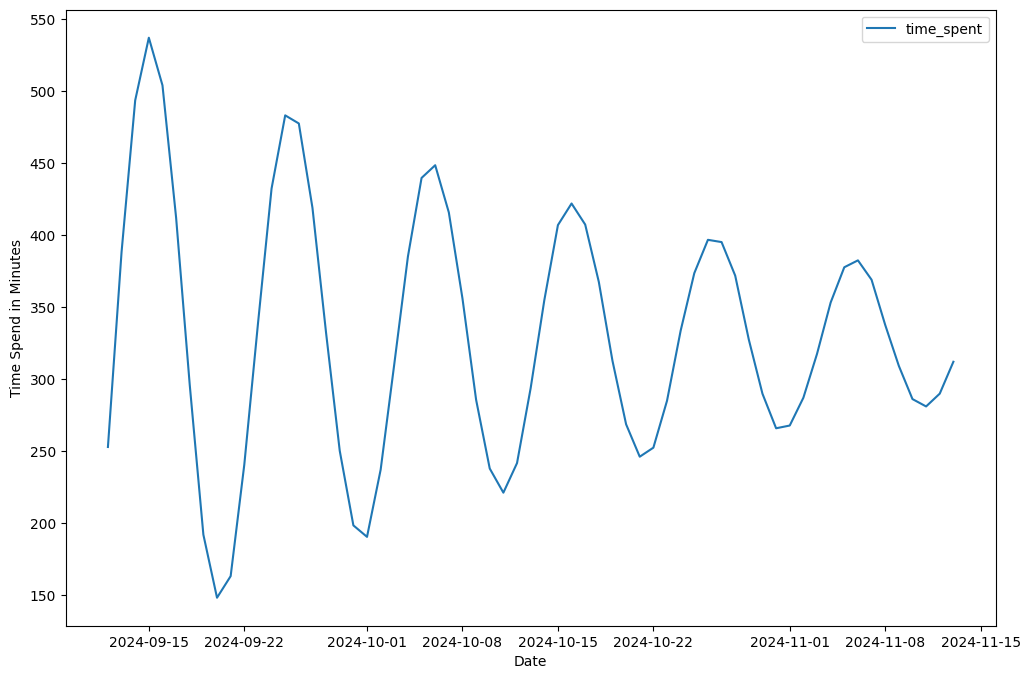

In [15]:
fig, ax = plt.subplots()

time_spent_df.plot(ax=ax, figsize=(12, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Time Spend in Minutes')
plt.show()

# Checking stationarity of data using ADF and Checking ACF and PACF

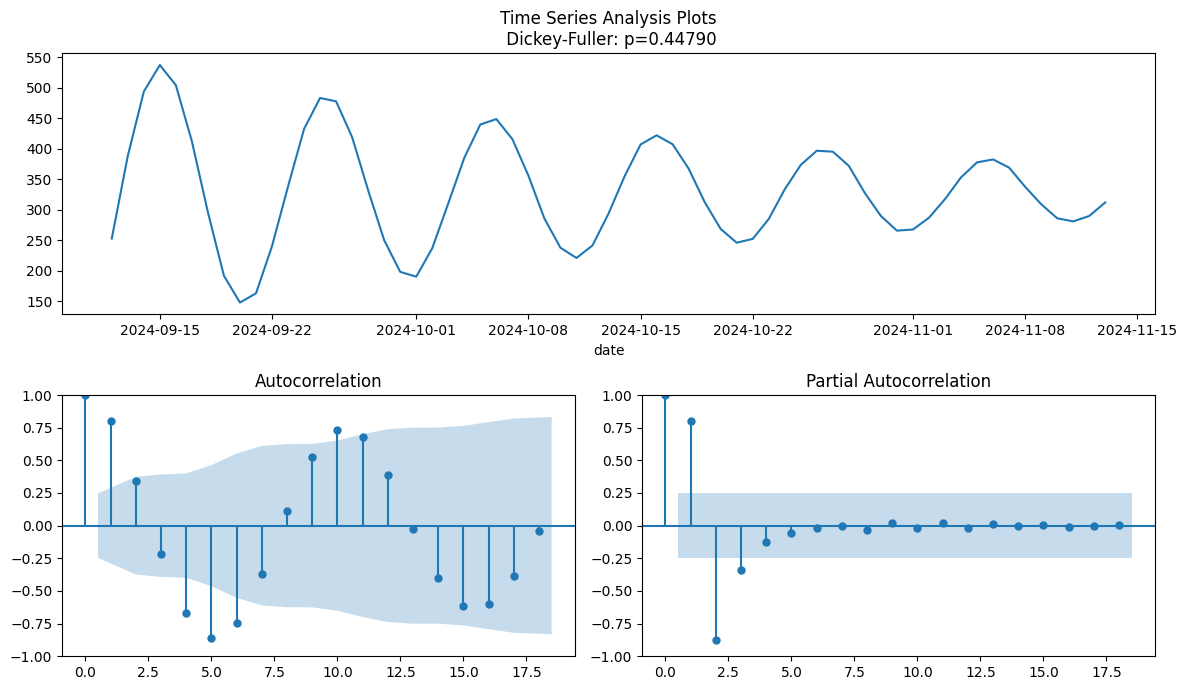

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(time_spent_df['time_spent'])

# Test, Train Split

In [17]:
data_train = time_spent_df['time_spent'][:-7]
data_test = time_spent_df['time_spent'][-7:]

#  Fitting different models

1. Manual ARIMA Fitting
    - choosing p, d, q manually
2. Auto ARIMA Fittting
3. ETS

### Ignoring warnings

In [18]:
import warnings
warnings.filterwarnings("ignore")

### Manual Fitting

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_train, order=(3,0,3), seasonal_order=(3, 0, 1, 7)).fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        time_spent   No. Observations:                   56
Model:             ARIMA(3, 0, 3)x(3, 0, [1], 7)   Log Likelihood                -158.870
Date:                           Sun, 19 Jan 2025   AIC                            341.739
Time:                                   23:10:42   BIC                            366.043
Sample:                               09-12-2024   HQIC                           351.162
                                    - 11-06-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        327.6600      0.894    366.449      0.000     325.907     329.412
ar.L1          0.6884      0.388      1.775

### Auto Fitting

In [20]:
import pmdarima as pm
auto_arima = pm.auto_arima(data_train, stepwise=False, seasonal=True)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -167.495
Date:                Sun, 19 Jan 2025   AIC                            346.990
Time:                        23:10:49   BIC                            359.142
Sample:                    09-12-2024   HQIC                           351.701
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    196.8837     60.912      3.232      0.001      77.497     316.270
ar.L1          0.9653      0.512      1.886      0.059      -0.038       1.969
ar.L2          0.1065      0.836      0.127      0.899      -1.533       1.746
ar.L3         -0.6729      0.510     -1.321      0.187      -1.671       0.326
ma.L1          0.4880      0.640      0.763      0.446      -0.766       1.742
sigma2        18.4803      3.914      4.721      0.000      10.808      26.152
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.87   Prob(JB):                         0.83
Heteroskedasticity (H):               0.33   Skew:                             0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ETS model

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit an Exponential Smoothing model
model_ETS = ExponentialSmoothing(data_train, seasonal='add', seasonal_periods=7).fit()

# Forecasting and Error Calculation


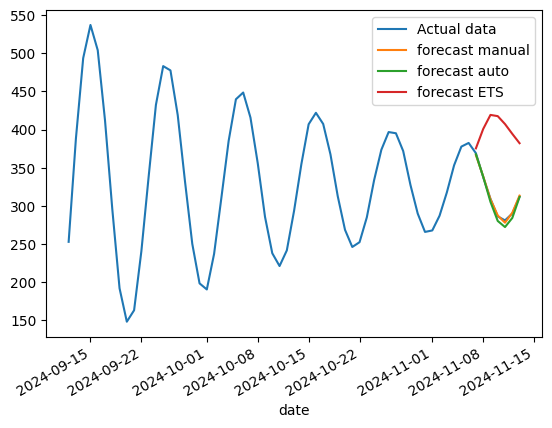

In [22]:
display_data = time_spent_df['time_spent'].copy()

fig, ax = plt.subplots()
display_data.plot(ax=ax, label='Actual data')
#ax.plot(display_data, label = 'Actual data')

forecast_test = model.forecast(steps = len(data_test))
forecast_test.plot(ax=ax, label='forecast manual')

forecast_test_auto = auto_arima.predict(n_periods=len(data_test))
forecast_test_auto.plot(ax=ax, label='forecast auto')

forecast_test_ETS = model_ETS.forecast(steps=len(data_test))
forecast_test_ETS.plot(ax=ax, label='forecast ETS')

plt.legend()
plt.show()

### Function for plotting individual models

In [35]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(data_test, forecast_test)
mape = mean_absolute_percentage_error(data_test, forecast_test)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test))
def plot_forecast(series_train, series_test, forecast, forecast_int=None, label = 'forecast'):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(ax = ax, label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label=label, color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

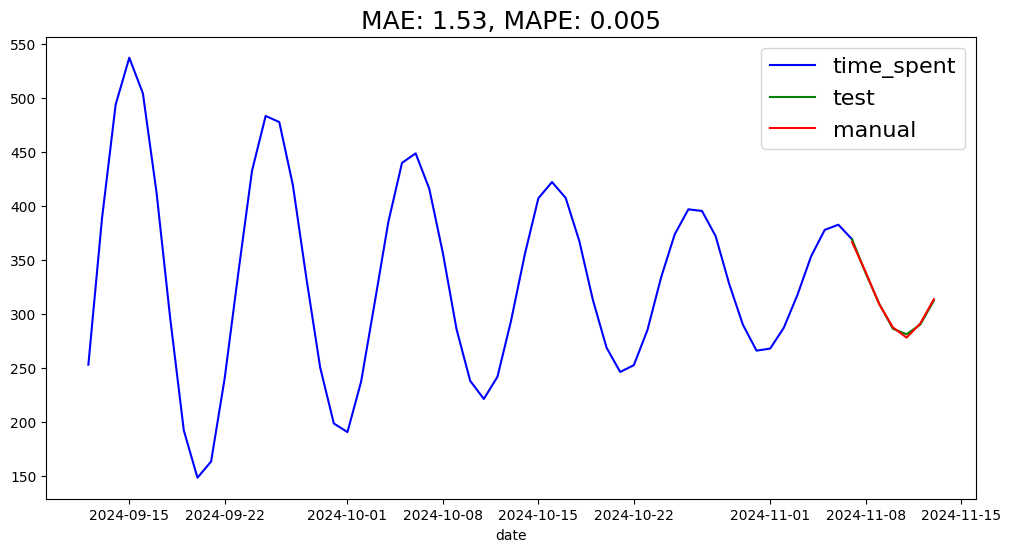

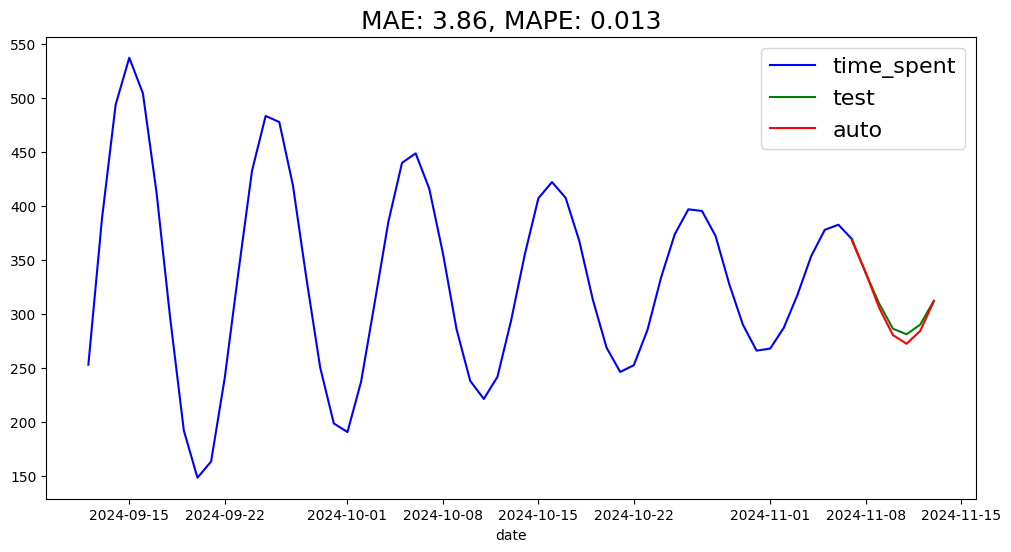

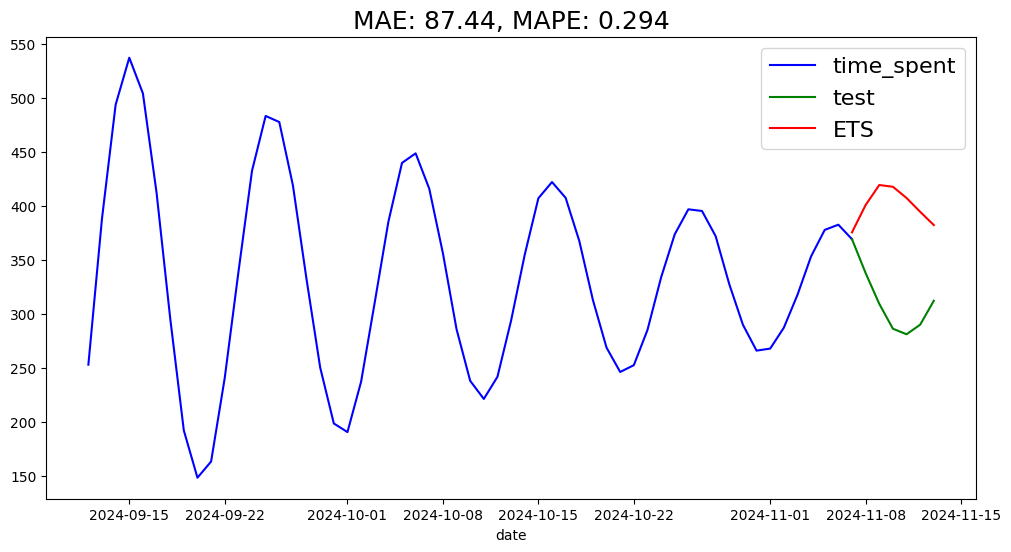

(87.43798359234155, 0.29350072987251136)

In [37]:
plot_forecast(time_spent_df[0:-6], data_test, forecast_test, label='manual')
plot_forecast(time_spent_df[0:-6], data_test, forecast_test_auto, label='auto')
plot_forecast(time_spent_df[0:-6], data_test, forecast_test_ETS, label = 'ETS')

### Error calculation for all 3 models

- MAE: Mean Absolute Error
- MAPE: Mam Absolute Percentage Error
- RMSE: Root Mean Squared Error

Manual ARIMA model gives the least error

In [38]:
mae = mean_absolute_error(data_test, forecast_test)
mape = mean_absolute_percentage_error(data_test, forecast_test)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 1.5328929046269681
mape - manual: 0.004941864946874452
rmse - manual: 1.758753614035383


In [25]:
mae = mean_absolute_error(data_test, forecast_test_auto)
mape = mean_absolute_percentage_error(data_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 3.86021613357244
mape - auto: 0.013154580161784227
rmse - auto: 4.840377942858184


In [26]:
mae = mean_absolute_error(data_test, forecast_test_ETS)
mape = mean_absolute_percentage_error(data_test, forecast_test_ETS)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_ETS))

print(f'mae - ETS: {mae}')
print(f'mape - ETS: {mape}')
print(f'rmse - ETS: {rmse}')

mae - ETS: 87.43798359234155
mape - ETS: 0.29350072987251136
rmse - ETS: 96.53754621985365
